<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>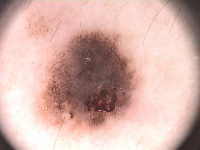</td><td>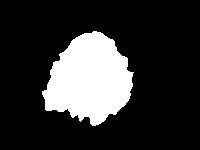</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
# ! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar
# ! gdown https://drive.google.com/uc?id=12eqGNI4twFQKiiGVoWKQiblVIsdLK1vw -O PH2Dataset.zip
# ! unzip -q /content/PH2Dataset.zip -d /content/PH2Dataset

In [1]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1VtEDXKLJSe0-x3RnQvlvZZv9bqKMte0h',
                                    dest_path='./PH2Dataset.rar',
                                    unzip=False)

In [2]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [4]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [5]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [6]:
len(lesions)

200

In [7]:
# define pytorch transforms
# transform = transforms.Compose([
#      transforms.ToPILImage(),
#      transforms.Resize((300, 300)),
#      transforms.CenterCrop((100, 100)),
#      transforms.RandomCrop((80, 80)),
#      transforms.RandomHorizontalFlip(p=0.5),
#      transforms.RandomRotation(degrees=(-90, 90)),
#      transforms.RandomVerticalFlip(p=0.5),
#      transforms.ToTensor(),
#      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
#      ])

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

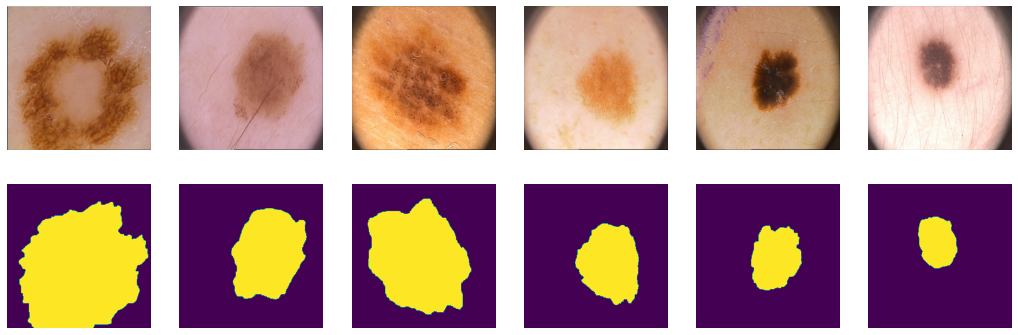

In [8]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


In [11]:
np.rollaxis(X[tr], 3, 1).shape

(100, 3, 256, 256)

#### PyTorch DataLoader

In [12]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True, num_workers=2)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True, num_workers=2)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True, num_workers=2)

In [13]:
import torch
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda


In [14]:
!nvidia-smi
torch.cuda.is_available()

Sun Dec 12 10:58:03 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

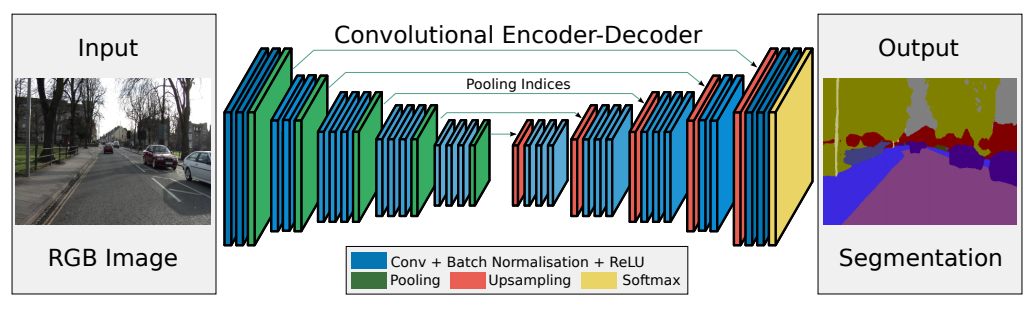

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torch.optim import lr_scheduler

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [16]:
import torchvision.models as models

In [17]:
# vgg16_bn = models.vgg16_bn(pretrained=False)

In [18]:
# print(vgg16_bn)

In [19]:
# model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

In [20]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )

        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
            # nn.Conv2d(64, 128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),
            # nn.ReLU())
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
            # nn.Conv2d(256, 256, kernel_size=3, padding=1),
            # nn.BatchNorm2d(256),
            # nn.ReLU())
        
        # self.pool1 = nn.MaxPool2d((2,2)) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        # self.pool2 = nn.MaxPool2d((2,2)) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        
        # self.pool3 = nn.MaxPool2d((2,2)) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

            # nn.MaxPool2d(),
            # nn.Upsample(scale_factor=2),

        self.bottleneck_dec_conv = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        # decoder (upsampling)
        self.upsample = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32

        self.dec_conv0 = self.enc_conv3

        # self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        # self.upsample2 = nn.Upsample(scale_factor=2)  # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
            # nn.Conv2d(128, 128, kernel_size=3, padding=1),
            # nn.BatchNorm2d(128),
            # nn.ReLU())

        # self.upsample3 = nn.Upsample(scale_factor=2)  # 128 -> 256

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1))
            # nn.ReLU(),
            # nn.Conv2d(64, 64, kernel_size=3, padding=1),
            # nn.BatchNorm2d(64)
            # ) # no activation

    def forward(self, x):
        # encoder
        e0, indices_0 = self.pool(self.enc_conv0(x))
        # print("e0 ", e0.shape)
        e1, indices_1 = self.pool(self.enc_conv1(e0))
        # print("e1 ", e1.shape)
        e2, indices_2 = self.pool(self.enc_conv2(e1))
        # print("e2 ", e2.shape)
        e3, indices_3 = self.pool(self.enc_conv3(e2))
        # print("e3 ", e3.shape)

        # bottleneck
        b, indices_b = self.pool(self.bottleneck_conv(e3))
        # print("b ", b.shape)
        # print("indices_b ", indices_b.shape)
        b = self.bottleneck_dec_conv(self.upsample(b, indices_b))
        # print("b ", b.shape)
        
        # decoder
        d0 = self.dec_conv0(self.upsample(b, indices_3))
        d1 = self.dec_conv1(self.upsample(d0, indices_2))
        d2 = self.dec_conv2(self.upsample(d1, indices_1))
        # print(d1.shape)
        # print(indices_1.shape)
        d3 = self.dec_conv3(self.upsample(d2, indices_0))  # no activation
        return d3

In [21]:
# model

In [22]:
# segnet = SegNet()
# print(segnet)

In [23]:
# for X_batch, Y_batch in data_tr:
#     # print(X_batch.shape)
#     # print(Y_batch.shape)
#     break

In [24]:
# for x, y in data_tr:
    # print(y[0][0][1])
    # y = y > 0.5
    # print(y)
    # break

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [25]:
sigm = torch.nn.Sigmoid()

In [26]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape

    # outputs = sigm(outputs)

    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    

    # print(outputs.shape)
    # print(labels.shape)

    # print(outputs[0][45])
    # print(labels[0][45])

    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    # thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return iou # thresholded  # 

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [27]:
def bce_loss(y_pred, y_real):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    eps = 1e-8
    return torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred + eps) + eps) + eps)

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [28]:
# pip install GPUtil

In [29]:
# import GPUtil

In [30]:
for x, y in data_val:
    print(x.shape)

torch.Size([25, 3, 256, 256])
torch.Size([25, 3, 256, 256])


In [31]:
len(data_val)

2

In [32]:
def train(model, opt, loss_fn, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))

    history = []

    # exp_lr_scheduler = lr_scheduler.StepLR(opt, step_size=4, gamma=0.1)

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_loss_val = 0

        running_loss = 0.0
        running_corrects = 0
        processed_data = 0

        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch = X_batch.to(DEVICE)
            Y_batch = Y_batch.to(DEVICE)
            # !nvidia-smi
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            # Y_pred = torch.sigmoid(Y_pred)
            # В лосс передаем выход с нейронки
            # А маску делаем только при валидации
            # Y_pred = (Y_pred >= 0.5).float()
            loss = loss_fn(Y_pred, Y_batch) # forward-pass
            loss.backward()  # backward-pass
            opt.step()  # update weights

            running_loss += loss.item() * X_batch.size(0)
            processed_data += X_batch.size(0)

            X_batch = X_batch.to('cpu')
            Y_batch = Y_batch.to('cpu')
            Y_pred = Y_pred.to('cpu')
            del X_batch, Y_batch, Y_pred
            torch.cuda.empty_cache()

            # calculate loss to show the user
            # avg_loss += loss / len(data_tr)
            
        # exp_lr_scheduler.step()

        avg_loss = running_loss / processed_data

        model.eval()
        for X_valid_loss, Y_valid_loss in data_val:
            X_valid_loss = X_valid_loss.to(DEVICE)
            Y_valid_loss = Y_valid_loss.to(DEVICE)

            with torch.set_grad_enabled(False):
                Y_pred_val = model(X_valid_loss)
                # Y_pred_val = torch.sigmoid(Y_pred_val)
                loss_val = loss_fn(Y_pred_val, Y_valid_loss)
            
            X_valid_loss = X_valid_loss.to('cpu')
            Y_valid_loss = Y_valid_loss.to('cpu')
            Y_pred_val = Y_pred_val.to('cpu')

            del X_valid_loss, Y_valid_loss, Y_pred_val
            torch.cuda.empty_cache()

            avg_loss_val += loss_val / len(data_val)
                

        toc = time()
        print('loss: %f' % avg_loss)
        print('loss on val: %f' % avg_loss_val)

        score_train = score_model(model, iou_pytorch, data_tr)
        score_val = score_model(model, iou_pytorch, data_val)

        history.append((avg_loss, avg_loss_val, score_train, score_val))

        # show intermediate results
        # model.eval()  # testing mode
        X_val = X_val.to(DEVICE)
        Y_hat = model(X_val) # detach and put into cpu

        # X_val = X_val.to('cpu')
        # del X_val

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.rollaxis(X_val.cpu()[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_val.cpu()[k, 0].numpy(), cmap='gray')
            plt.title('True')
            plt.axis('off')

            plt.subplot(3, 6, k+13)
            plt.imshow(Y_hat.cpu()[k, 0].detach().numpy(), cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()

        X_val = X_val.to('cpu')
        Y_hat = Y_hat.cpu()
        del Y_hat
    return history

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [33]:
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [34]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:

        # GPUtil.showUtilization()

        X_batch = X_batch.to(DEVICE)
        Y_label = Y_label.to(DEVICE)

        with torch.set_grad_enabled(False):
            Y_pred = model(X_batch)
            Y_pred = torch.sigmoid(Y_pred)
            Y_pred = (Y_pred >= 0.5).float()
            scores += metric(Y_pred, Y_label).mean().item()

        # GPUtil.showUtilization()

        # for k in range(6):
        #     plt.subplot(3, 6, k+1)
        #     plt.imshow(np.rollaxis(X_batch.cpu()[k].numpy(), 0, 3), cmap='gray')
        #     plt.title('Real')
        #     plt.axis('off')

        #     plt.subplot(3, 6, k+7)
        #     plt.imshow(Y_label.cpu()[k, 0].numpy(), cmap='gray')
        #     plt.title('True')
        #     plt.axis('off')

        #     plt.subplot(3, 6, k+13)
        #     plt.imshow(Y_pred.cpu()[k, 0].detach().numpy(), cmap='gray')
        #     plt.title('Output')
        #     plt.axis('off')
        # # plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        # plt.show()


        X_batch = X_batch.to('cpu')
        Y_label = Y_label.to('cpu')
        del X_batch, Y_label

        # GPUtil.showUtilization()

        # break
    return scores/len(data)

In [35]:
# for X_batch, Y_label in data_val:
#     X_batch = X_batch.to(DEVICE)
#     Y_pred = model(X_batch).cpu()
#     X_batch = X_batch.to('cpu')
#     del X_batch
#     print(Y_label.shape)
#     print(Y_label)
#     break

In [36]:
# Y_pred.shape

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [37]:
# torch.cuda.empty_cache()

In [38]:
!nvidia-smi

Sun Dec 12 10:58:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    27W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
model = SegNet().to(DEVICE)

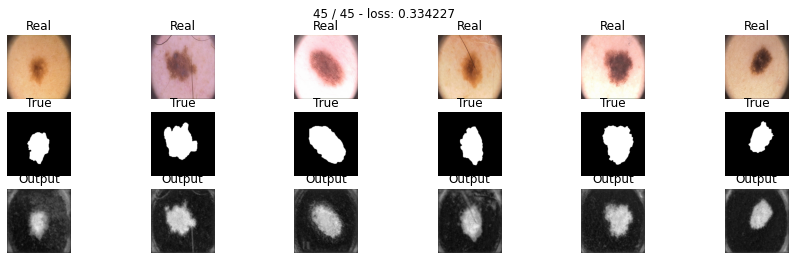

In [ ]:
max_epochs = 45
opt = torch.optim.Adam(model.parameters())
history_bce = train(model, opt, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
# torch.save(model.state_dict(), "SegNet_150_bceloss.pth")

In [ ]:
# model.load_state_dict(torch.load("SegNet_80_bceloss.pth"))
#  map_location=torch.device('cpu')

<All keys matched successfully>

In [ ]:
# type(history_bce)

list

In [60]:
loss_bce, val_loss_bce, score_train_bce, score_val_bce = zip(*history_bce)

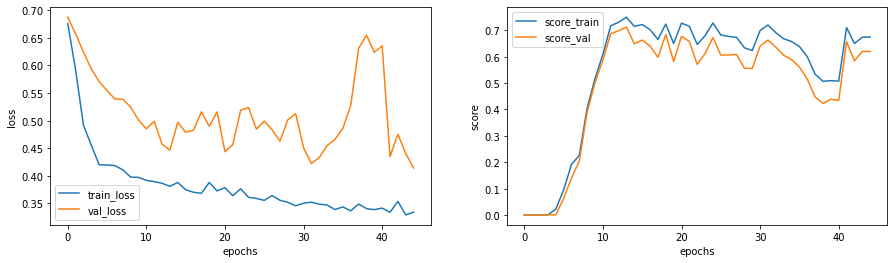

In [76]:
plt.subplot(1, 2, 1)
plt.plot(loss_bce, label="train_loss")
plt.plot(val_loss_bce, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(score_train_bce, label="score_train")
plt.plot(score_val_bce, label="score_val")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

None

In [ ]:
# скор на 80 - 0.737
# скор на 150 - 0.763

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6198405027389526

In [ ]:
t1 = torch.randn(64, 1, 256, 256)
t2 = torch.randn(64, 1, 256, 256)
print(nn.BCEWithLogitsLoss()(t1, t2), bce_loss(t1, t2))

tensor(0.8057) tensor(0.8057)


Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
# t1 = torch.tensor(1).to(DEVICE)
# t2 = torch.tensor(2).to(DEVICE)
# t_SMOOTH = torch.tensor(1).to(DEVICE)
def dice_loss(y_pred, y_real):
    y_pred = torch.sigmoid(y_pred)
    # num = (y_pred * y_real * t2).sum()
    # den = (y_pred + y_real).sum() + t_SMOOTH
    # res = t1 - ((num / den).sum())
    num = 2*torch.sum(y_real*y_pred, (1,2,3))
    den = torch.sum(y_real, (1,2,3)) + torch.sum(y_pred, (1,2,3))
    res = 1 - torch.mean((num+1) / (den+1))
    return res

Проводим тестирование:

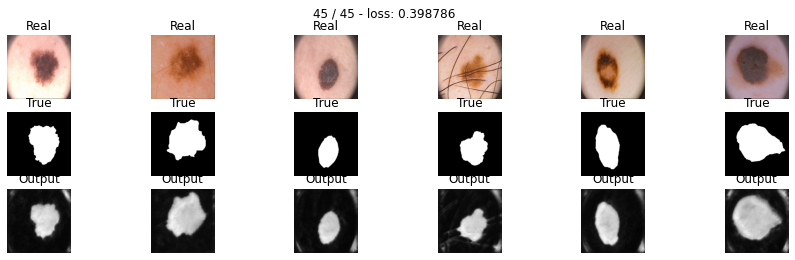

In [ ]:
model_dice = SegNet().to(DEVICE)

max_epochs = 45
optimaizer = optim.Adam(model_dice.parameters())
history_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
# torch.save(model_dice.state_dict(), "SegNet_40_diceloss.pth")

In [94]:
loss_dice, val_loss_dice, score_train_dice, score_val_dice = zip(*history_dice)

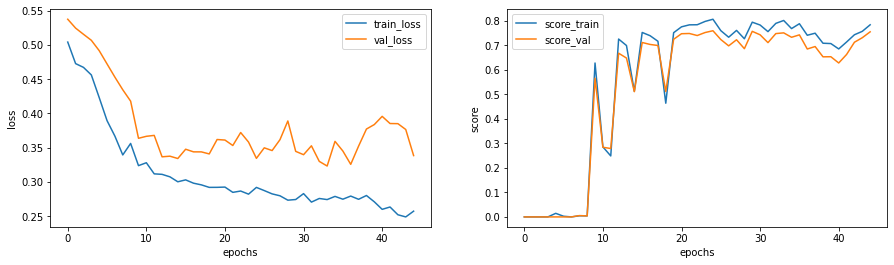

In [95]:
plt.subplot(1, 2, 1)
plt.plot(loss_dice, label="train_loss")
plt.plot(val_loss_dice, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(score_train_dice, label="score_train")
plt.plot(score_val_dice, label="score_val")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

None

In [ ]:
# plt.figure(figsize=(15, 9))
# plt.plot(loss_dice, label="train_loss")
# plt.plot(val_loss_dice, label="val_loss")
# plt.legend(loc='best')
# plt.xlabel("epochs")
# plt.ylabel("loss")
# plt.show()

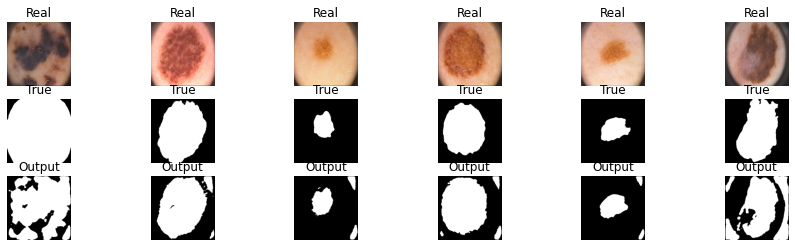

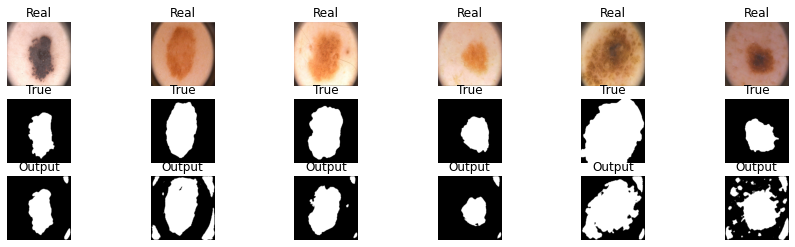

0.7333330512046814

In [ ]:
# dice loss
# 20 epoch - 0.73 score
score_model(model_dice, iou_pytorch, data_val)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_pred, y_real, eps = 1e-8, gamma = 2):
    # # y_pred =  # hint: torch.clamp
    # y_pred = y_pred.clamp(eps, 1.0 - eps)
    y_pred = torch.sigmoid(y_pred)
    my_loss1 = - (1 - y_pred + eps)**gamma * y_real * torch.log(y_pred + eps)
    # assert (my_loss1 != my_loss1).any(), "My loss is Nan"
    my_loss2 = - (1 - y_real) * torch.log(1 - y_pred + eps)
    # assert (my_loss2 != my_loss2).any(), "My loss is Nan"
    my_loss = torch.mean((my_loss1 + my_loss2))
    # # print("my_loss1: ", my_loss1)
    # # print("my_loss2: ", my_loss2)
    # print("my_loss: ", my_loss)
    # my_loss = torch.mean(y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))
    
    # log_probs = -torch.log(y_pred)
    # focal_loss = torch.sum(torch.pow(1 - y_pred + eps, gamma).mul(log_probs).mul(y_real), dim=1)
    # my_loss = focal_loss.mean()


    return my_loss


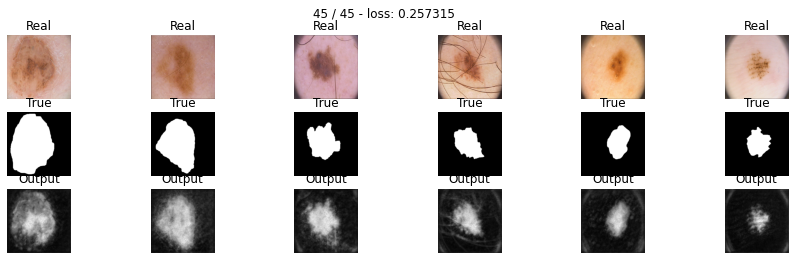

In [ ]:
model_focal = SegNet().to(DEVICE)

max_epochs = 45
optimaizer = optim.Adam(model_focal.parameters())
history_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
# torch.save(model_focal.state_dict(), "SegNet_45_focalloss.pth")

In [92]:
loss_focal, val_loss_focal, score_train_focal, score_val_focal = zip(*history_focal)

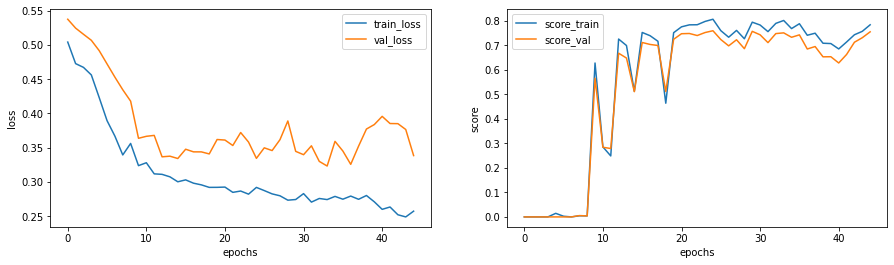

In [93]:
plt.subplot(1, 2, 1)
plt.plot(loss_focal, label="train_loss")
plt.plot(val_loss_focal, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(score_train_focal, label="score_train")
plt.plot(score_val_focal, label="score_val")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

None

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.754828929901123

Text(0, 0.5, 'score')

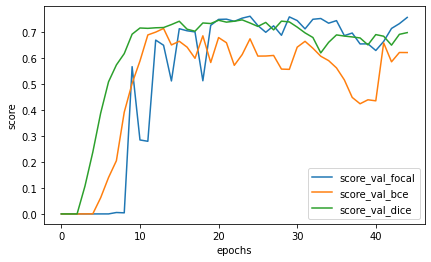

In [ ]:
plt.subplot(1, 2, 2)
plt.plot(score_val_focal, label="score_val_focal")
plt.plot(score_val_bce, label="score_val_bce")
plt.plot(score_val_dice, label="score_val_dice")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

In [45]:
import pickle
import random

In [ ]:
# def save_data(data):
#     with open("bin_history_bce.dat", "wb") as f:
#         pickle.dump(data, f)

In [ ]:
# save_data(history_bce)

In [88]:
# def load_data():
#     with open("bin_history_focal.dat", 'rb') as f:
#         x = pickle.load(f)
#     return x

In [89]:
# history_focal = load_data()

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [54]:
def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1:  # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard


class LovaszSoftmax(nn.Module):
    def __init__(self, reduction='mean'):
        super(LovaszSoftmax, self).__init__()
        self.reduction = reduction

    def prob_flatten(self, input, target):
        assert input.dim() in [4, 5]
        num_class = input.size(1)
        if input.dim() == 4:
            input = input.permute(0, 2, 3, 1).contiguous()
            input_flatten = input.view(-1, num_class)
        elif input.dim() == 5:
            input = input.permute(0, 2, 3, 4, 1).contiguous()
            input_flatten = input.view(-1, num_class)
        target_flatten = target.view(-1)
        return input_flatten, target_flatten

    def lovasz_softmax_flat(self, inputs, targets):
        num_classes = inputs.size(1)
        losses = []
        for c in range(num_classes):
            target_c = (targets == c).float()
            if num_classes == 1:
                input_c = inputs[:, 0]
            else:
                input_c = inputs[:, c]
            loss_c = (torch.autograd.Variable(target_c) - input_c).abs()
            loss_c_sorted, loss_index = torch.sort(loss_c, 0, descending=True)
            target_c_sorted = target_c[loss_index]
            losses.append(torch.dot(loss_c_sorted, torch.autograd.Variable(lovasz_grad(target_c_sorted))))
        losses = torch.stack(losses)

        if self.reduction == 'none':
            loss = losses
        elif self.reduction == 'sum':
            loss = losses.sum()
        else:
            loss = losses.mean()
        return loss

    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs, targets = self.prob_flatten(inputs, targets)
        losses = self.lovasz_softmax_flat(inputs, targets)
        return losses

In [55]:
Loss = LovaszSoftmax()

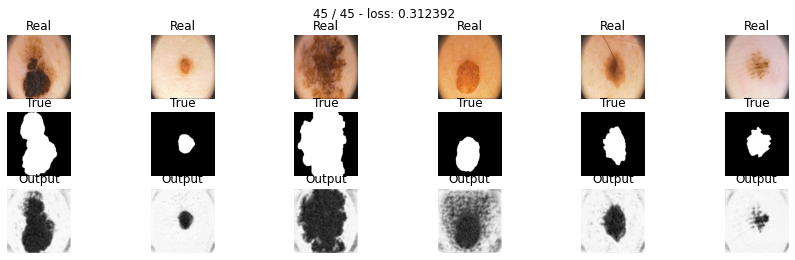

In [ ]:
model_lovasz = SegNet().to(DEVICE)

max_epochs = 45
optimaizer = optim.Adam(model_lovasz.parameters())
history_lovasz = train(model_lovasz, optimaizer, Loss, max_epochs, data_tr, data_val)

In [61]:
loss_lovasz, val_loss_lovasz, score_train_lovasz, score_val_lovasz = zip(*history_lovasz)

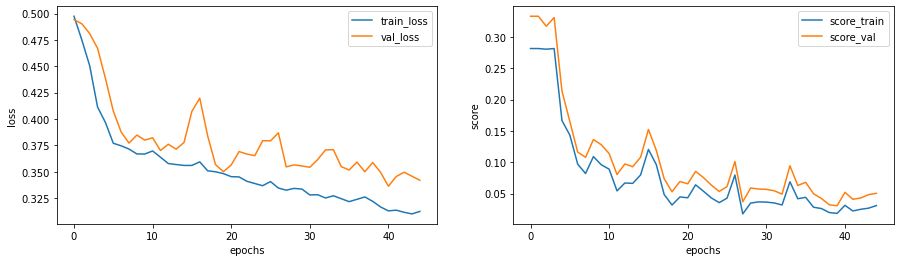

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(loss_lovasz, label="train_loss")
plt.plot(val_loss_lovasz, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(score_train_lovasz, label="score_train")
plt.plot(score_val_lovasz, label="score_val")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

None

In [ ]:
def save_data(data):
    with open("bin_history_lovasz.dat", "wb") as f:
        pickle.dump(data, f)

In [ ]:
save_data(history_lovasz)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

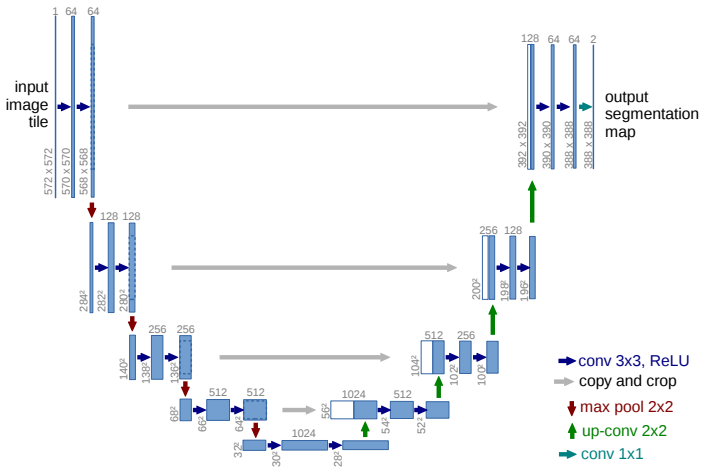

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

In [ ]:
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

In [ ]:
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        # self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.up = nn.Upsample(scale_factor=(2,2) , mode='nearest')
        self.conv = conv_block(out_c+out_c, out_c)
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=1)
    def forward(self, inputs, skip):
        # print("inputs before upsample : ",inputs.shape)
        # print("skip: ", skip.shape)
        x = self.up(inputs)
        x = self.conv1(x)
        # print("inputs: ",inputs.shape)
        # print("skip: ", skip.shape)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(3, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

In [ ]:
unet_model = UNet().to(DEVICE)

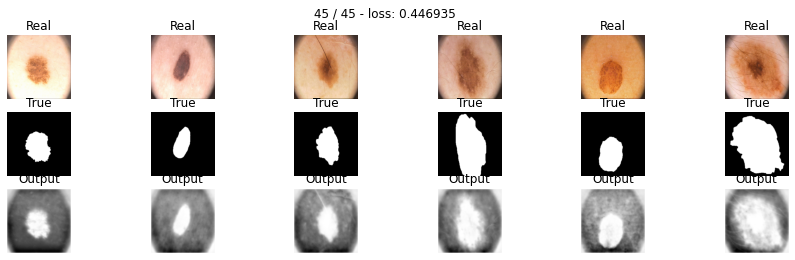

In [ ]:
max_epochs = 45
optimaizer = optim.Adam(unet_model.parameters())
history_unet_bce = train(unet_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
loss_unet_bce, val_loss_unet_bce, score_train_unet_bce, score_val_unet_bce = zip(*history_unet_bce)

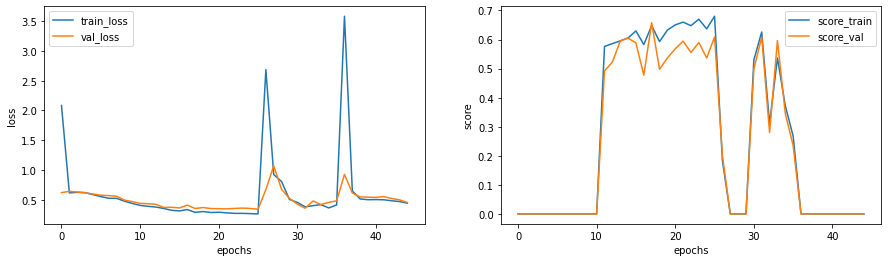

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(loss_unet_bce, label="train_loss")
plt.plot(train_loss_bce, label="val_loss")
plt.plot(val_loss_unet_bce, label="val_loss")
plt.plot(val_loss_unet_bce, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(score_train_unet_bce, label="score_train")
plt.plot(score_val_unet_bce, label="score_val")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

None

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

8.852990497805469e-13

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class conv_block_unet2(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        # self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        # self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
    def forward(self, inputs):
        x = self.conv1(inputs)
        # x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        # x = self.bn2(x)
        x = self.relu(x)
        return x

In [ ]:
class encoder_block_unet2(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block_unet2(in_c, out_c)
        self.pool = nn.Conv2d(out_c, out_c, kernel_size=3, stride=2, padding=1)
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

In [ ]:
class decoder_block_unet2(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block_unet2(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block_unet2(3, 64)
        self.e2 = encoder_block_unet2(64, 128)
        self.e3 = encoder_block_unet2(128, 256)
        self.e4 = encoder_block_unet2(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block_unet2(1024, 512)
        self.d2 = decoder_block_unet2(512, 256)
        self.d3 = decoder_block_unet2(256, 128)
        self.d4 = decoder_block_unet2(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

In [ ]:
unet2_model = UNet2().to(DEVICE)

In [56]:
max_epochs = 45
optimaizer = optim.Adam(unet2_model.parameters())
histiry_unet2_bce = train(unet2_model, optimaizer, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
loss_unet2_bce, val_loss_unet2_bce, score_train_unet2_bce, score_val_unet2_bce = zip(*histiry_unet2_bce)

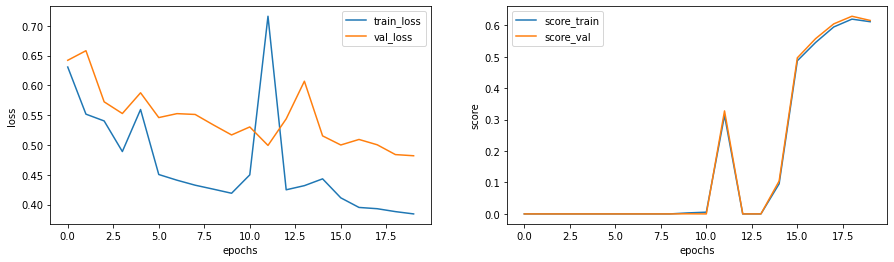

In [ ]:
plt.subplot(1, 2, 1)
plt.plot(loss_unet2_bce, label="train_loss")
plt.plot(val_loss_unet2_bce, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(score_train_unet2_bce, label="score_train")
plt.plot(score_val_unet2_bce, label="score_val")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

None

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

### Функции ошибок - лосс
Как много в этом слове...

### Что мы хотим увидеть/понять? Как интерпретировать результаты?
Наверное это основные вопросы, которые возникали у меня в процессе выполнения этой домашней работы, и на которые я успешно или же нет пытался сам для себя ответить.

1. Начну со второго вопроса (в начале ноутбука был похожий - переобучается ли наша модель?). И да, скорее всего она переобучается. Данных для такой глубокой архитектуры явно недостаточно. По-хорошему, как предлагали в чате, следовало бы написать собственный класс и добавить туда аугментации, что, могу предположить, улучшило бы показатели. Отчасти поэтому я и использую относительно небольшое количество эпох - 45, потому что более смысла не имеет без аугментации (хотя, наверное и 45 много...)

2. Предлагается написать несколько архитектур, несколько лоссов. И также логично предположить, что они предназначены для различных задач. Хотя нейронки обучаются на всех лоссах.

В процессе изучения лоссов, становится более менее понятно на чем именно они фокусируются и за что "штрафуют" модель больше. Так, например:
Focal loss - пытается фокусироваться на сложных примерах, уменьшая вклад простых;
Dice - дифференцируемая метрика IOU (большую роль играет пересечение "правльных" меток).
И насколько могу понять Dice для конктретно нашей задачи будет далеко не идеальным, ведь размер родинки/опухоли относительно всего изображения может быть небольшим и модель может вообще не выделять ничего, лосс все также будет относительно большим.

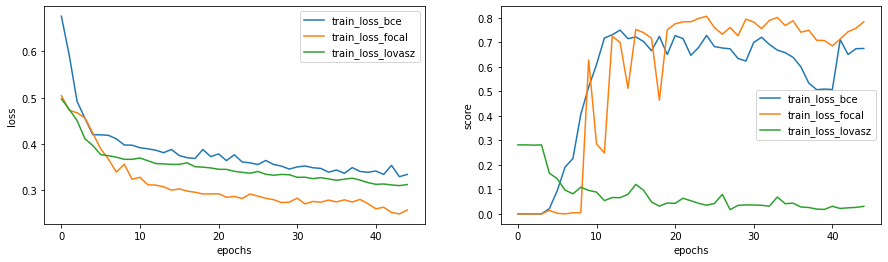

In [98]:
plt.subplot(1, 2, 1)
plt.plot(loss_bce, label="train_loss_bce")
plt.plot(loss_focal, label="train_loss_focal")
plt.plot(loss_lovasz, label="train_loss_lovasz")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(score_train_bce, label="train_loss_bce")
plt.plot(score_train_focal, label="train_loss_focal")
plt.plot(score_train_lovasz, label="train_loss_lovasz")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

None

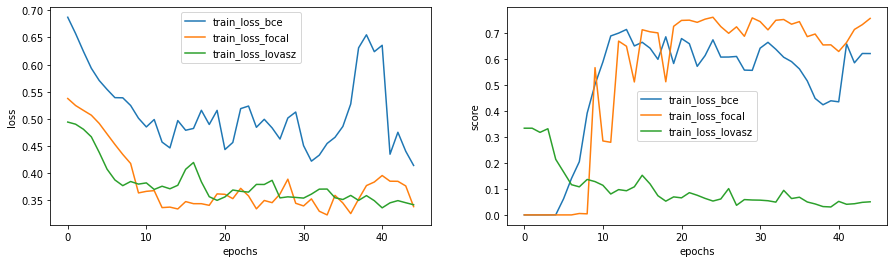

In [99]:
plt.subplot(1, 2, 1)
plt.plot(val_loss_bce, label="train_loss_bce")
plt.plot(val_loss_focal, label="train_loss_focal")
plt.plot(val_loss_lovasz, label="train_loss_lovasz")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")

plt.subplot(1, 2, 2)
plt.plot(score_val_bce, label="train_loss_bce")
plt.plot(score_val_focal, label="train_loss_focal")
plt.plot(score_val_lovasz, label="train_loss_lovasz")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("score")

None

Не уверен что графики очень презентативны, возможно ошибся где-то в реализации. В Unet-е так уж точно, там графики получаются совсем некорректные. Последний лосс LovaszLoss показывает прям очень неплохой результат особенно на контрасте с остальными.

### Вывод
На самом деле не знаю, какой именно должен быть вывод из этой исследовательской работы. Но наглядно видно как влияет функция ошибок в обучении, а именно правильный её выбор. Возможно из-за ошибок в реализации какого-то кода, возможно еще из-за чего-то. Но смотря на результаты Segnet-а и Unet-а, по идее более свежая новая архитектура должна быть лучше. Но создается впечатление, что нет. В процессе обучения неронной сети, когда выводятся промежуточные результаты, кажется что результат больше зависит от лосс функции, чем от архитектуры. Возможно в этом был сакральный смысл работы, разобраться на должном уровне с имеющимися возможностями и существующими решениями и не гнаться за самой последней и глубокой архитектурой.